In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

# Current directory
print(os.getcwd())

# change directory
os.chdir('/content/drive/MyDrive/python_training/NLP100Days-part2/D10_pytorch_model_training/')
print(os.getcwd())

/content
/content/drive/MyDrive/python_training/NLP100Days-part2/D10_pytorch_model_training


In [3]:
#!unzip spam_data.zip

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import codecs
import re

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

## 資料準備 : 詳細介紹可參考NLP第一階段課程Day20,21

In [5]:
all_data=[]
paths =[r'spam_data/spam', r'spam_data/easy_ham', r'spam_data/hard_ham'] 
for path in paths:
    for fn in glob.glob(path+"/*"):
        if "ham" not in fn:
            is_spam = 1
        else:
            is_spam = 0
        #codecs.open可以避開錯誤，用errors='ignore'
        with codecs.open(fn,encoding='utf-8', errors='ignore') as file:
            for line in file:
                #這個line的開頭為Subject:
                if line.startswith("Subject:"):
                    subject=re.sub(r"^Subject:","",line).strip()
                    all_data.append([subject,is_spam])
all_data = np.array(all_data)

In [6]:
all_data

array([['Friend, Copy ANY DVD or Playstation Game with this software......',
        '1'],
       ['5% Guaranteed for Eight Years', '1'],
       ['Congratulations! You Get a Free Handheld Organizer!', '1'],
       ...,
       ['blogged item', '0'],
       ["Great deals on the Summer's hottest MP3 players (CNET SHOPPER)",
        '0'],
       ["IBM's thin ThinkPads fit to a T", '0']], dtype='<U109')

In [7]:
X = all_data[:,0]
Y = all_data[:,1].astype(np.uint8)

In [8]:
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords

import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Lemmatize with POS Tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer


# Lemmatize with POS Tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

## 創建Lemmatizer
lemmatizer = WordNetLemmatizer() 
def get_wordnet_pos(word):
    """將pos_tag結果mapping到lemmatizer中pos的格式"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def clean_content(X):
    # remove non-alphabet characters
    X_clean = [re.sub('[^a-zA-Z]',' ', x).lower() for x in X]
    # tokenize
    X_word_tokenize = [nltk.word_tokenize(x) for x in X_clean]
    # stopwords_lemmatizer
    X_stopwords_lemmatizer = []
    stop_words = set(stopwords.words('english'))
    for content in X_word_tokenize:
        content_clean = []
        for word in content:
            if word not in stop_words:
                word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
                content_clean.append(word)
        X_stopwords_lemmatizer.append(content_clean)
    
    X_output = [' '.join(x) for x in X_stopwords_lemmatizer]
    
    return X_output
                 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
X = clean_content(X)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
#max_features是要建造幾個column，會按造字出現的頻率高低去篩選，1500並沒有特別含義，大家可以自己嘗試不同數值或不加入限制
cv=CountVectorizer(max_features = 1500)
X=cv.fit_transform(X).toarray()

In [11]:
from sklearn.model_selection import train_test_split
# random_state是為了讓各為學員得到相同的結果，平時可以移除
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [12]:
x_train.shape

(2738, 1500)

In [13]:
np.unique(y_train)

array([0, 1], dtype=uint8)

### 判斷是否有GPU可以使用

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### 模型搭建

In [15]:
class LinearBNAC(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True, dropout=0.3, is_output=False):
        super(LinearBNAC, self).__init__()
        if is_output:
            self.linear = nn.Linear(in_channels, out_channels, bias=bias)
        else:
            self.linear = nn.Sequential(
                nn.Linear(in_channels, out_channels, bias=bias),
                nn.BatchNorm1d(out_channels),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(dropout),
            )
            
    def forward(self, x):
        out=self.linear(x)
        return out

In [16]:
class Model(nn.Module):
    def __init__(self, input_dimention, output_classes=1):
        super(Model, self).__init__()
        self.layer1 = LinearBNAC(input_dimention, 16)
        self.layer2 = LinearBNAC(16, 32)
        self.output = LinearBNAC(32, output_classes, is_output=True)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output(x)
        return x  
        

### 建立模型

* to(device) 代表轉成 cpu or gpu 模式 (gpu 模式下稱為 cuda)

In [17]:
model = Model(input_dimention=1500,output_classes=2).to(device)

In [18]:
for name,_ in model.named_parameters():
    print(name, _.shape)

layer1.linear.0.weight torch.Size([16, 1500])
layer1.linear.0.bias torch.Size([16])
layer1.linear.1.weight torch.Size([16])
layer1.linear.1.bias torch.Size([16])
layer2.linear.0.weight torch.Size([32, 16])
layer2.linear.0.bias torch.Size([32])
layer2.linear.1.weight torch.Size([32])
layer2.linear.1.bias torch.Size([32])
output.linear.weight torch.Size([2, 32])
output.linear.bias torch.Size([2])


In [19]:
batch_size = 4
input_features = 1500
dummy_input = torch.randn(batch_size, input_features).to(device)


In [20]:
output = model(dummy_input)
print(output)

tensor([[-0.3386, -0.5004],
        [ 0.3249, -0.1081],
        [-0.4305, -0.2354],
        [-1.1248,  0.0225]], grad_fn=<AddmmBackward>)


## Loss

#### classification

In [21]:
from torch.nn import NLLLoss, LogSoftmax, CrossEntropyLoss

In [22]:
## CrossEntropyLoss = LogSoftmax + NLLLoss

* CrossEntropyLoss

In [23]:
criterion = CrossEntropyLoss()

## optimizer

In [24]:
import torch.optim as optim

* params : iterable of parameters
* lr : learning rate
* weight_decay : (L2) Regularization (正則化) 

In [25]:
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

### 訓練前準備

In [26]:
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)

y_train_numpy = y_train.copy()
y_test_numpy = y_test.copy()

y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [27]:
batch_size = 4
epochs = 50
softmax = nn.Softmax(-1)

index = np.array([x for x in range(len(x_train))])

### 訓練

In [28]:
train_loss_ = []
test_loss_ = []
train_accuracy_ = []
test_accuracy_ = []
for epoch in range(epochs):
    
    np.random.shuffle(index)
    x_train = x_train[index]
    y_train = y_train[index]

    loss_keeper = []
    model.train()
    
    for batch in range(len(x_train)//batch_size):
        x = x_train[batch*batch_size : (batch+1)*batch_size,:]
        y = y_train[batch*batch_size : (batch+1)*batch_size]
        output = model(x)
        loss_train = criterion(output, y)
        loss_train.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_train = loss_train.detach().cpu().item()
        loss_keeper.append(loss_train)    
    
    model.eval()
    output = model(x_test)
    prediction = softmax(output)
    prediction = torch.argmax(prediction,1).detach().cpu().numpy()
    test_accuracy = metrics.accuracy_score(prediction, y_test_numpy)
    loss_test = criterion(output, y_test)
    loss_test = loss_test.detach().cpu().item()
    train_loss_.append(np.mean(loss_keeper))
    test_loss_.append(loss_test)
    
    if epoch % 2 == 0:
        print('epoch : {}'.format(epoch))
        print('目前 train loss : {:.2f}'.format(np.mean(loss_keeper)))
        print('目前 test loss : {:.2f}'.format(loss_test))
        print('目前 test accuracy : {:.2f}'.format(test_accuracy))


epoch : 0
目前 train loss : 0.43
目前 test loss : 0.38
目前 test accuracy : 0.86
epoch : 2
目前 train loss : 0.31
目前 test loss : 0.27
目前 test accuracy : 0.92
epoch : 4
目前 train loss : 0.27
目前 test loss : 0.24
目前 test accuracy : 0.93
epoch : 6
目前 train loss : 0.24
目前 test loss : 0.21
目前 test accuracy : 0.93
epoch : 8
目前 train loss : 0.21
目前 test loss : 0.22
目前 test accuracy : 0.91
epoch : 10
目前 train loss : 0.21
目前 test loss : 0.19
目前 test accuracy : 0.93
epoch : 12
目前 train loss : 0.20
目前 test loss : 0.18
目前 test accuracy : 0.93
epoch : 14
目前 train loss : 0.19
目前 test loss : 0.19
目前 test accuracy : 0.93
epoch : 16
目前 train loss : 0.19
目前 test loss : 0.19
目前 test accuracy : 0.92
epoch : 18
目前 train loss : 0.17
目前 test loss : 0.18
目前 test accuracy : 0.93
epoch : 20
目前 train loss : 0.17
目前 test loss : 0.18
目前 test accuracy : 0.93
epoch : 22
目前 train loss : 0.16
目前 test loss : 0.22
目前 test accuracy : 0.92
epoch : 24
目前 train loss : 0.15
目前 test loss : 0.20
目前 test accuracy : 0.93
epoch : 26
目前 tra

In [29]:
print(classification_report(prediction, y_test_numpy))


              precision    recall  f1-score   support

           0       0.93      0.96      0.94       570
           1       0.76      0.64      0.69       115

    accuracy                           0.91       685
   macro avg       0.84      0.80      0.82       685
weighted avg       0.90      0.91      0.90       685



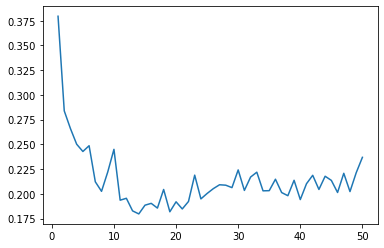

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, len(test_loss_)+1), test_loss_)
plt.show()

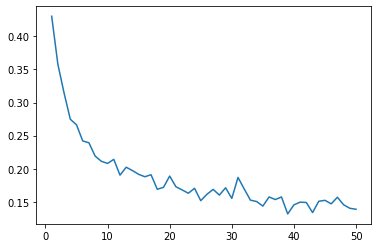

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, len(train_loss_)+1), train_loss_)
plt.show()

---

### 儲存跟載入 weight

### 儲存

In [32]:
##假設我們已經訓練好了模型
## 可以存成 .pth or .pt
saving_location = './model_save-d10.pth' # './' 代表目前所屬路徑
torch.save({'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'loss': loss_test
           }, f=saving_location)


### 載入 

In [33]:
model = Model(input_dimention=1500,output_classes=2).to(device)

##載入
checkpoint = torch.load(saving_location, map_location=lambda storage, loc: storage)
#model.load_state_dict(checkpoint)
model.load_state_dict(checkpoint['model_state_dict'])
print('loading successfully...')
print('\n')

model.eval()

test_content = ['Congratulations! You Get a Free Handheld Organizer!']
test_content = clean_content(test_content)
test_content=cv.transform(test_content).toarray()
test_content = torch.tensor(test_content, dtype=torch.float32).to(device)
output = model(test_content)
prediction = softmax(output)
prediction = torch.argmax(prediction,1).detach().cpu().numpy()[0]

if prediction == 1:
    print('Is spam')
else:
    print('Not spam')

loading successfully...


Is spam
